In [ ]:
#! pip install torchinfo

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torchvision.transforms as transforms

import torchvision

from numpy.random import seed
import torch
import numpy as np

from torchinfo import summary
import matplotlib.pyplot as plt

In [ ]:
# Load dataset

train_dataset = torchvision.datasets.FashionMNIST('./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST('./data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

In [ ]:
# Randomly select 6000 for training

N = len(train_dataset)
train_dataset = Subset(train_dataset, np.random.choice(N, 6000, replace=False))

In [ ]:
# Split dataset into training and evaluation

N = len(train_dataset)
train_size = int(0.7*N)
train_dataset, val_dataset = random_split(train_dataset,\
                                          lengths=[train_size, N - train_size])

print(f'Train dataset length: {len(train_dataset)}')
print(f'Validation dataset length: {len(val_dataset)}')


Train dataset length: 4200
Validation dataset length: 1800


image tensor: torch.Size([32, 1, 28, 28])
class labels: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])


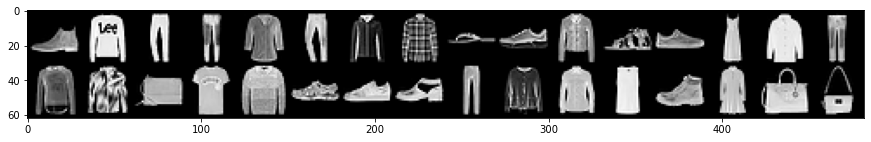

In [ ]:
# Show some images from test dataset

batch_size = 32

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
imgs, labels = next(iter(test_loader))
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=16, ncols=2, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {labels}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

## Creating a CNN model to classify images 



In [ ]:
# Fix random number so that your traing process can be replicated

random_seed = 124
seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        # conv net
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),  # (48, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #(32, 14, 14)  if stride is not provided, it will default to kernel_size
            nn.Conv2d(in_channels=64, out_channels=24, kernel_size=2),  # (24, 12, 12)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 6, 6)        
            nn.Flatten() ,           
            nn.Dropout(0.5),
            nn.Linear(in_features = 24*6*6, out_features = 100),
            nn.Dropout(0.2),
            nn.Linear(in_features = 100, out_features = 10)
        )
       
    def forward(self, x):
        output = self.convnet(x)
    
        return output

In [ ]:
class linear_model(nn.Module):
    
    # hidden_units is a list which specify the output of each layer
    def __init__(self, input_dim = 784, hidden_units=[256]):
        
        # initialize parent class
        super(linear_model, self).__init__()
        
        hidden_units = [input_dim] + hidden_units
        
        self.layers = nn.ModuleList([nn.Linear(hidden_units[i], hidden_units[i+1]) \
                                     for i in range(len(hidden_units)-1)])
    
    def forward(self, x):
        
        output = x
        #print(x.size())
        for i, layer in enumerate(self.layers):
            
            output = layer(output)
            #print(output.size())
            
            if i<len(self.layers)-1:   # no activation on the last layer
                output = F.relu(output)
        
        return output

In [ ]:
def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                optimizer, epochs=30, batch_size=128):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / y.size(0)
            
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                
                # predict
                outputs = model(x)
                _, pred = torch.max(outputs, dim = -1)
                cur_val_loss = criterion(outputs, y)
                cur_val_acc = (pred == y).sum().item() / y.size(0) 
                
                # loss and acc
                val_loss += cur_val_loss
                val_acc += cur_val_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (val_loss/len(val_loader)).item()
        val_acc = val_acc/len(val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.3f} train_acc:{train_acc:.3f}, valid loss:{val_loss:.3f} valid acc:{val_acc:.3f}")
    

    model.eval()
    ys = []
    preds = []

    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)

            # predict
            outputs = model(x)
            _, pred = torch.max(outputs, dim = -1)

            preds.append(pred.view(-1).cpu().numpy())
            ys.append(y)

    ys = np.concatenate(ys)
    preds = np.concatenate(preds)

    test_acc = (ys==preds).astype(int).sum()/len(ys)
    print(f"test acc:{test_acc:.3f}")

    return test_acc, history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# dataset

modela = cnn_model()
summary(modela, (32, 1, 28, 28))

optimizer = torch.optim.RMSprop(modela.parameters(), lr = 0.0005)
acc_a, hista = train_model(modela, train_dataset, val_dataset, test_dataset, device, optimizer, epochs=200)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                --                        --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 64, 26, 26]          640
│    └─ReLU: 2-2                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 64, 13, 13]          --
│    └─Conv2d: 2-4                       [32, 24, 12, 12]          6,168
│    └─ReLU: 2-5                         [32, 24, 12, 12]          --
│    └─MaxPool2d: 2-6                    [32, 24, 6, 6]            --
│    └─Flatten: 2-7                      [32, 864]                 --
│    └─Dropout: 2-8                      [32, 864]                 --
│    └─Linear: 2-9                       [32, 100]                 86,500
│    └─Dropout: 2-10                     [32, 100]                 --
│    └─Linear: 2-11                      [32, 10]                  1,010
Tota

Training Start
Epoch:1 / 200, train loss:1.276 train_acc:0.553, valid loss:0.824 valid acc:0.725
Epoch:2 / 200, train loss:0.800 train_acc:0.709, valid loss:0.708 valid acc:0.711
Epoch:3 / 200, train loss:0.719 train_acc:0.735, valid loss:0.665 valid acc:0.735
Epoch:4 / 200, train loss:0.684 train_acc:0.748, valid loss:0.624 valid acc:0.753
Epoch:5 / 200, train loss:0.648 train_acc:0.762, valid loss:0.593 valid acc:0.769
Epoch:6 / 200, train loss:0.625 train_acc:0.773, valid loss:0.574 valid acc:0.785
Epoch:7 / 200, train loss:0.613 train_acc:0.764, valid loss:0.556 valid acc:0.779
Epoch:8 / 200, train loss:0.595 train_acc:0.777, valid loss:0.535 valid acc:0.804
Epoch:9 / 200, train loss:0.590 train_acc:0.780, valid loss:0.540 valid acc:0.795
Epoch:10 / 200, train loss:0.558 train_acc:0.792, valid loss:0.529 valid acc:0.803
Epoch:11 / 200, train loss:0.554 train_acc:0.800, valid loss:0.497 valid acc:0.821
Epoch:12 / 200, train loss:0.559 train_acc:0.790, valid loss:0.521 valid acc:0.80

Epoch:100 / 200, train loss:0.314 train_acc:0.883, valid loss:0.377 valid acc:0.874
Epoch:101 / 200, train loss:0.308 train_acc:0.885, valid loss:0.367 valid acc:0.869
Epoch:102 / 200, train loss:0.305 train_acc:0.888, valid loss:0.376 valid acc:0.874
Epoch:103 / 200, train loss:0.301 train_acc:0.889, valid loss:0.374 valid acc:0.870
Epoch:104 / 200, train loss:0.312 train_acc:0.886, valid loss:0.383 valid acc:0.869
Epoch:105 / 200, train loss:0.303 train_acc:0.891, valid loss:0.375 valid acc:0.869
Epoch:106 / 200, train loss:0.302 train_acc:0.890, valid loss:0.382 valid acc:0.866
Epoch:107 / 200, train loss:0.300 train_acc:0.890, valid loss:0.381 valid acc:0.865
Epoch:108 / 200, train loss:0.307 train_acc:0.887, valid loss:0.377 valid acc:0.871
Epoch:109 / 200, train loss:0.286 train_acc:0.893, valid loss:0.369 valid acc:0.870
Epoch:110 / 200, train loss:0.301 train_acc:0.890, valid loss:0.368 valid acc:0.876
Epoch:111 / 200, train loss:0.295 train_acc:0.894, valid loss:0.371 valid ac

Epoch:198 / 200, train loss:0.227 train_acc:0.919, valid loss:0.372 valid acc:0.882
Epoch:199 / 200, train loss:0.238 train_acc:0.914, valid loss:0.359 valid acc:0.884
Epoch:200 / 200, train loss:0.219 train_acc:0.920, valid loss:0.368 valid acc:0.874
test acc:0.870


In [ ]:
def get_plot(hist_list, labels, epochs):
    
    colors = ['red',"blue","green","orange"]
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    for i, hist in enumerate(hist_list):
        ax[0].plot(range(len(hist['val_loss'])), hist['val_loss'], '-', color = colors[i], label=labels[i])
        
    ax[0].set_title('Evaluation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    for i, hist in enumerate(hist_list):
        ax[1].plot(range(len(hist['val_acc'])), hist['val_acc'], '-', color = colors[i], label=labels[i])
        

    ax[1].set_title('Evaluation Acc.')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc.')
    ax[1].legend()
   
    plt.show()

Test acc: model A 0.870


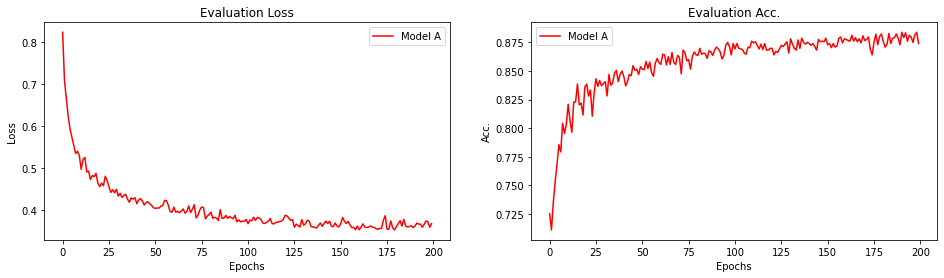

In [ ]:
print(f"Test acc: model A {acc_a:.3f}")

get_plot([hista], ["Model A"], len(hista['val_loss']))

## Improve model performance with augmentation

In [ ]:
# dataset with augmentation

class Fashion_Dataset(Dataset):
    def __init__(self, dataset, transformer = None):
        
        self.dataset = dataset
        
        self.transformer = transformer
    
    def __getitem__(self, index):
        # load image
        
        img, label = self.dataset[index]
        if self.transformer:
            img = self.transformer(img)
       
        return img, label
    
    def __len__(self):
        return len(self.dataset)  
    
    
def show_img(img):
    plt.figure(figsize=(5,4))  
    plt.imshow(np.transpose(img, axes=(1,2,0)), cmap="gray")

In [ ]:
# data augmentation

transform = transforms.Compose([
            transforms.GaussianBlur(1),
            transforms.RandomResizedCrop((28,28), scale=(0.9, 1.1))
            ])


In [ ]:
fashion_dataset = Fashion_Dataset(train_dataset, transformer = transform)
len(fashion_dataset)

4200

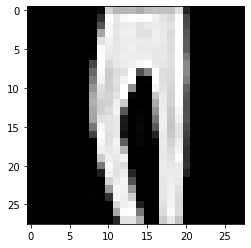

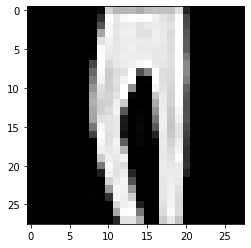

In [ ]:
# Test transformation
imgs, labels = train_dataset[0]
show_img(imgs)
# #x = imgs.view(1, *imgs.size())
# #x.size()

imgs, label = fashion_dataset[0]
show_img(imgs)

In [ ]:
modelb = cnn_model()
summary(modelb, (32, 1, 28, 28))


optimizer = torch.optim.RMSprop(modelb.parameters(), lr = 0.0008)
acc_b, histb = train_model(modelb, fashion_dataset, val_dataset, test_dataset, device, optimizer, epochs=200)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                --                        --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 64, 26, 26]          640
│    └─ReLU: 2-2                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 64, 13, 13]          --
│    └─Conv2d: 2-4                       [32, 24, 12, 12]          6,168
│    └─ReLU: 2-5                         [32, 24, 12, 12]          --
│    └─MaxPool2d: 2-6                    [32, 24, 6, 6]            --
│    └─Flatten: 2-7                      [32, 864]                 --
│    └─Dropout: 2-8                      [32, 864]                 --
│    └─Linear: 2-9                       [32, 100]                 86,500
│    └─Dropout: 2-10                     [32, 100]                 --
│    └─Linear: 2-11                      [32, 10]                  1,010
Tota

Training Start
Epoch:1 / 200, train loss:1.322 train_acc:0.513, valid loss:0.770 valid acc:0.718
Epoch:2 / 200, train loss:0.823 train_acc:0.698, valid loss:0.663 valid acc:0.765
Epoch:3 / 200, train loss:0.721 train_acc:0.730, valid loss:0.622 valid acc:0.757
Epoch:4 / 200, train loss:0.657 train_acc:0.750, valid loss:0.561 valid acc:0.787
Epoch:5 / 200, train loss:0.644 train_acc:0.765, valid loss:0.525 valid acc:0.804
Epoch:6 / 200, train loss:0.631 train_acc:0.765, valid loss:0.526 valid acc:0.803
Epoch:7 / 200, train loss:0.614 train_acc:0.771, valid loss:0.491 valid acc:0.817
Epoch:8 / 200, train loss:0.597 train_acc:0.783, valid loss:0.475 valid acc:0.829
Epoch:9 / 200, train loss:0.581 train_acc:0.786, valid loss:0.484 valid acc:0.814
Epoch:10 / 200, train loss:0.573 train_acc:0.790, valid loss:0.479 valid acc:0.822
Epoch:11 / 200, train loss:0.565 train_acc:0.794, valid loss:0.466 valid acc:0.829
Epoch:12 / 200, train loss:0.549 train_acc:0.798, valid loss:0.486 valid acc:0.81

Epoch:100 / 200, train loss:0.381 train_acc:0.857, valid loss:0.341 valid acc:0.872
Epoch:101 / 200, train loss:0.376 train_acc:0.864, valid loss:0.377 valid acc:0.863
Epoch:102 / 200, train loss:0.364 train_acc:0.864, valid loss:0.362 valid acc:0.864
Epoch:103 / 200, train loss:0.376 train_acc:0.860, valid loss:0.337 valid acc:0.870
Epoch:104 / 200, train loss:0.381 train_acc:0.857, valid loss:0.355 valid acc:0.879
Epoch:105 / 200, train loss:0.374 train_acc:0.859, valid loss:0.364 valid acc:0.871
Epoch:106 / 200, train loss:0.378 train_acc:0.865, valid loss:0.348 valid acc:0.870
Epoch:107 / 200, train loss:0.368 train_acc:0.863, valid loss:0.342 valid acc:0.874
Epoch:108 / 200, train loss:0.354 train_acc:0.866, valid loss:0.369 valid acc:0.862
Epoch:109 / 200, train loss:0.365 train_acc:0.861, valid loss:0.355 valid acc:0.867
Epoch:110 / 200, train loss:0.368 train_acc:0.865, valid loss:0.345 valid acc:0.874
Epoch:111 / 200, train loss:0.356 train_acc:0.864, valid loss:0.339 valid ac

Epoch:198 / 200, train loss:0.316 train_acc:0.883, valid loss:0.314 valid acc:0.883
Epoch:199 / 200, train loss:0.318 train_acc:0.885, valid loss:0.319 valid acc:0.880
Epoch:200 / 200, train loss:0.323 train_acc:0.878, valid loss:0.348 valid acc:0.874
test acc:0.870


In [ ]:
modelb = cnn_model()
summary(modelb, (32, 1, 28, 28))


optimizer = torch.optim.Adam(modelb.parameters(), lr = 0.0008)
acc_b, histb = train_model(modelb, fashion_dataset, val_dataset, test_dataset, device, optimizer, epochs=200)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                --                        --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 64, 26, 26]          640
│    └─ReLU: 2-2                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 64, 13, 13]          --
│    └─Conv2d: 2-4                       [32, 24, 12, 12]          6,168
│    └─ReLU: 2-5                         [32, 24, 12, 12]          --
│    └─MaxPool2d: 2-6                    [32, 24, 6, 6]            --
│    └─Flatten: 2-7                      [32, 864]                 --
│    └─Dropout: 2-8                      [32, 864]                 --
│    └─Linear: 2-9                       [32, 100]                 86,500
│    └─Dropout: 2-10                     [32, 100]                 --
│    └─Linear: 2-11                      [32, 10]                  1,010
Tota

Training Start
Epoch:1 / 200, train loss:1.723 train_acc:0.412, valid loss:0.915 valid acc:0.679
Epoch:2 / 200, train loss:0.891 train_acc:0.670, valid loss:0.713 valid acc:0.726
Epoch:3 / 200, train loss:0.746 train_acc:0.718, valid loss:0.618 valid acc:0.781
Epoch:4 / 200, train loss:0.684 train_acc:0.738, valid loss:0.575 valid acc:0.795
Epoch:5 / 200, train loss:0.655 train_acc:0.759, valid loss:0.559 valid acc:0.799
Epoch:6 / 200, train loss:0.630 train_acc:0.772, valid loss:0.545 valid acc:0.794
Epoch:7 / 200, train loss:0.618 train_acc:0.769, valid loss:0.532 valid acc:0.804
Epoch:8 / 200, train loss:0.594 train_acc:0.776, valid loss:0.511 valid acc:0.818
Epoch:9 / 200, train loss:0.571 train_acc:0.794, valid loss:0.484 valid acc:0.824
Epoch:10 / 200, train loss:0.574 train_acc:0.789, valid loss:0.490 valid acc:0.819
Epoch:11 / 200, train loss:0.538 train_acc:0.809, valid loss:0.492 valid acc:0.825
Epoch:12 / 200, train loss:0.541 train_acc:0.803, valid loss:0.459 valid acc:0.83

Epoch:100 / 200, train loss:0.347 train_acc:0.870, valid loss:0.347 valid acc:0.874
Epoch:101 / 200, train loss:0.338 train_acc:0.878, valid loss:0.331 valid acc:0.879
Epoch:102 / 200, train loss:0.343 train_acc:0.871, valid loss:0.341 valid acc:0.875
Epoch:103 / 200, train loss:0.337 train_acc:0.876, valid loss:0.336 valid acc:0.880
Epoch:104 / 200, train loss:0.333 train_acc:0.879, valid loss:0.348 valid acc:0.869
Epoch:105 / 200, train loss:0.333 train_acc:0.878, valid loss:0.328 valid acc:0.885
Epoch:106 / 200, train loss:0.335 train_acc:0.874, valid loss:0.333 valid acc:0.880
Epoch:107 / 200, train loss:0.322 train_acc:0.879, valid loss:0.346 valid acc:0.880
Epoch:108 / 200, train loss:0.333 train_acc:0.877, valid loss:0.331 valid acc:0.880
Epoch:109 / 200, train loss:0.332 train_acc:0.874, valid loss:0.346 valid acc:0.873
Epoch:110 / 200, train loss:0.327 train_acc:0.883, valid loss:0.333 valid acc:0.876
Epoch:111 / 200, train loss:0.327 train_acc:0.875, valid loss:0.327 valid ac

Epoch:198 / 200, train loss:0.281 train_acc:0.902, valid loss:0.317 valid acc:0.889
Epoch:199 / 200, train loss:0.288 train_acc:0.892, valid loss:0.329 valid acc:0.882
Epoch:200 / 200, train loss:0.279 train_acc:0.891, valid loss:0.322 valid acc:0.886
test acc:0.884


Test acc: model A 0.870, model B 0.884


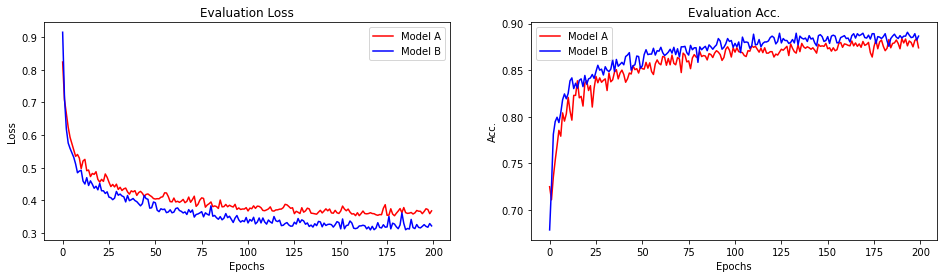

In [ ]:
print(f"Test acc: model A {acc_a:.3f}, model B {acc_b:.3f}")

get_plot([hista, histb], ["Model A","Model B"], len(hista['val_loss']))